# Import

In [5]:
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from mae import *
import networkx as nx
import torch
from models import VariationalAutoEncoder, DenoiseNN
from torch_geometric.data import DataLoader
from data import base_preprocess_dataset
from ggsp.models import sample
from ggsp.utils import linear_beta_schedule

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import argparse
import torch
import logging
from torch_geometric.loader import DataLoader
from typing import Union

from ggsp.data import *
from ggsp.models import VariationalAutoEncoder, DenoiseNN
from ggsp.train import train_autoencoder, train_denoiser
from ggsp.utils import load_model_checkpoint
from ggsp.utils.noising_schedule import *
from ggsp.runners import generate_submission
from ggsp.metrics import absolute_loss_features
from ggsp.models import sample

# Load graph

In [9]:
import yaml 

yaml_file = "/Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/run/experiment_13/config.yaml"
with open(yaml_file, "r") as file:
        yaml_data = yaml.safe_load(file)  # Parse the YAML content as a dictionary

In [10]:
autoencoder = VariationalAutoEncoder(
    yaml_data["spectral_emb_dim"] + 1,
    yaml_data["hidden_dim_encoder"],
    yaml_data["hidden_dim_decoder"],
    yaml_data["latent_dim"],
    yaml_data["n_layers_encoder"],
    yaml_data["n_layers_decoder"],
    yaml_data["n_max_nodes"],
    yaml_data["encoder_classname"],
    yaml_data["decoder_classname"],
    )
# Load the weights from /Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/run/experiment_1/checkpoints/best_autoencoder_checkpoint.pth.tar
autoencoder.load_state_dict(torch.load("/Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/run/experiment_13/checkpoints/best_autoencoder_checkpoint.pth.tar")["state_dict"])

autoencoder.encoder.eval()
autoencoder.decoder.eval()

/var/folders/pb/_7l8b_td5_jfqdxkmrdd2gf40000gn/T/ipykernel_40008/672385305.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("/User

Decoder(
  (mlp): ModuleList(
    (0): Linear(in_features=38, out_features=481, bias=True)
    (1-3): 3 x Linear(in_features=481, out_features=481, bias=True)
    (4): Linear(in_features=481, out_features=2450, bias=True)
  )
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [11]:
denoise_model = DenoiseNN(
        input_dim=yaml_data["latent_dim"],
        hidden_dim=yaml_data["hidden_dim_denoise"],
        n_layers=yaml_data["n_layers_denoise"],
        n_cond=yaml_data["n_condition"],
        d_cond=yaml_data["dim_condition"],
    )
# Load the weights from /Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/run/experiment_1/checkpoints/best_denoiser_checkpoint.pth.tar
denoise_model.load_state_dict(torch.load("/Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/run/experiment_13/checkpoints/best_denoiser_checkpoint.pth.tar")["state_dict"])

denoise_model.eval()

/var/folders/pb/_7l8b_td5_jfqdxkmrdd2gf40000gn/T/ipykernel_40008/341688481.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoise_model.load_state_dict(torch.load("/Use

DenoiseNN(
  (cond_mlp): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (mlp): ModuleList(
    (0): Linear(in_features=166, out_features=512, bias=True)
    (1): Linear(in_features=640, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=38, bias=True)
  )
  (bn): ModuleList(
    (0-1): 2 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (tanh): Tanh()
)

# Infer the model

In [12]:
trainset = globals()[yaml_data["dataset_preprocessing_function"]](
        "../../../data", "train", yaml_data["n_max_nodes"], yaml_data["spectral_emb_dim"]
    )

train_loader = DataLoader(
        trainset, batch_size=6, shuffle=False
    )

/Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/src/ggsp/metrics/../data/preprocess.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_lst = torch.load(filename)
/Use

In [13]:
for i in range(len(trainset)):
    if trainset[i].filename=="graph_838":
        print(i)
        break

7924


In [14]:
data = trainset[7924]

print(f"Data: {data}")
x_g = autoencoder.encode(data)
print(f"Embeddings: {x_g}")
t = torch.randint(
            0, yaml_data["timesteps"], (x_g.size(0),)).long()
x_d = denoise_model(x_g, t, data.stats)
print(f"Reconstructed embeddings: {x_d}")
x_hat = autoencoder.decode_mu(x_d)
print(f"Reconstructed graph: {x_hat}")

Data: Data(x=[10, 11], edge_index=[2, 32], A=[1, 50, 50], stats=[1, 7], filename='graph_838')
Embeddings: tensor([[ 0.9645,  0.2768,  0.2658, -0.0145,  0.5038, -1.0547, -0.7417,  0.5650,
         -0.3406, -1.0120, -0.2181,  0.6213,  0.0200, -0.3399,  1.5423, -0.1918,
         -0.9669, -1.1200,  0.7761, -0.1482,  2.2895, -1.1343, -0.8752, -0.1339,
         -0.3641,  0.7807, -0.2334, -1.0662,  0.8235,  1.9917,  1.6201, -0.1128,
          1.4827,  0.5940,  1.1930, -2.7596, -0.5481,  0.0385]],
       grad_fn=<AddBackward0>)
Reconstructed embeddings: tensor([[ 1.3215,  0.3739,  0.3306, -0.2407,  0.7323, -1.4807, -0.9925,  0.8842,
         -0.4013, -1.3852, -0.3490,  0.5795, -0.1301, -0.4183,  2.4473, -0.2771,
         -1.6569, -1.6394,  1.0296, -0.1796,  3.1177, -1.5042, -1.2525,  0.0594,
         -0.0073,  0.9354, -0.3040, -1.4269,  1.0163,  2.5873,  2.1138, -0.1787,
          2.1192,  0.7671,  1.5555, -3.7883, -0.9772, -0.1705]],
       grad_fn=<AddmmBackward0>)
Reconstructed graph: tenso

In [97]:
data = trainset[0]

samples = sample(
    denoise_model,
    cond=data.stats,
    latent_dim=yaml_data["latent_dim"],
    timesteps=yaml_data["timesteps"],
    betas= globals()["linear_beta_schedule"](timesteps=yaml_data["timesteps"]),
    batch_size=1,
)
x_sample = samples[-1]
adj = autoencoder.decode_mu(x_sample)
adj

tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<AddBackward0>)

In [98]:
data.A

tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [99]:
compute_features(adj.squeeze())

array([ 44.        , 175.        ,   7.95454545, 168.        ,
         0.25791094,   6.        ,   6.        ])

In [100]:
compute_features(data.A.squeeze())

array([2.90000000e+01, 2.49000000e+02, 1.71724138e+01, 9.05000000e+02,
       6.75050514e-01, 1.50000000e+01, 2.00000000e+00])

In [66]:
mae(adj, data.A)

np.float64(225.67949320287553)

In [67]:
data.stats[0]

tensor([ 40.0000, 221.0000,  11.0500, 226.0000,   0.2866,   8.0000,   4.0000])

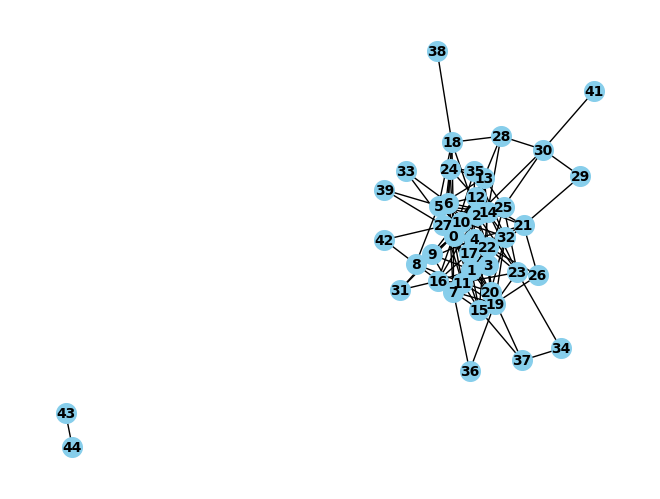

In [68]:
G = nx.from_numpy_array(adj.squeeze().detach().numpy(), create_using=nx.Graph)
to_remove = []
for node in G.nodes():
    if G.degree(node) == 0:
        to_remove.append(node)
G.remove_nodes_from(to_remove)
nx.draw(G, with_labels=True, font_weight='bold', node_color='skyblue', node_size=200, font_size=10)

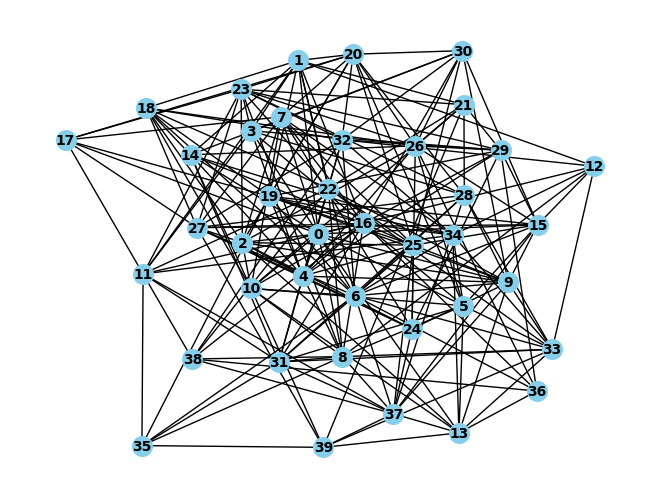

In [69]:
G_target = nx.from_numpy_array(data.A.squeeze().numpy(), create_using=nx.Graph)
to_remove = []
for node in G_target.nodes():
    if G_target.degree(node) == 0:
        to_remove.append(node)
G_target.remove_nodes_from(to_remove)
nx.draw(G_target, with_labels=True, font_weight='bold', node_color='skyblue', node_size=200, font_size=10)

In [61]:
for i in range(len(trainset)):
    if trainset[i].filename == "graph_838":
        print(i)
        break

7924


In [62]:
trainset[7924].stats

tensor([[10.0000, 16.0000,  3.2000,  7.0000,  0.2958,  2.0000,  2.0000]])

In [63]:
compute_features(trainset[7924].A.squeeze())

array([10.        , 16.        ,  3.2       ,  7.        ,  0.74444444,
        2.        ,  1.        ])

In [67]:
trainset[7924].A

tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

# Test autoencoder

In [105]:
input = trainset[0]
x = autoencoder.encode(input)
print(x.shape)
output = autoencoder.decode_mu(x)
output

torch.Size([1, 38])


tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<AddBackward0>)

In [106]:
mae(output, input.A)

np.float64(912.138367868395)

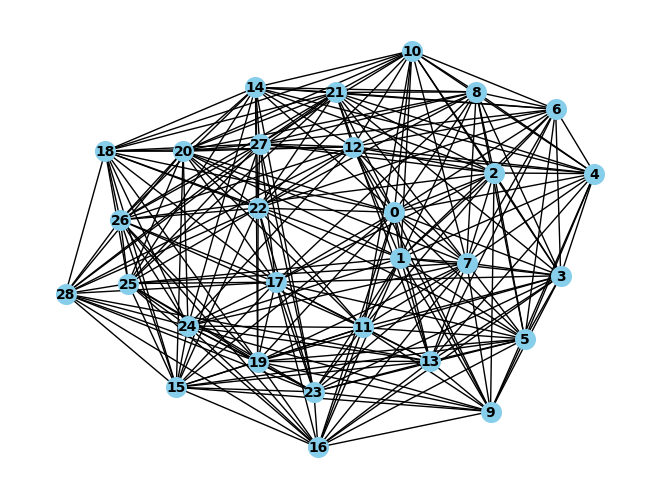

In [111]:
G_target = nx.from_numpy_array(input.A.squeeze().numpy(), create_using=nx.Graph)
to_remove = []
for node in G_target.nodes():
    if G_target.degree(node) == 0:
        to_remove.append(node)
G_target.remove_nodes_from(to_remove)
nx.draw(G_target, with_labels=True, font_weight='bold', node_color='skyblue', node_size=200, font_size=10)

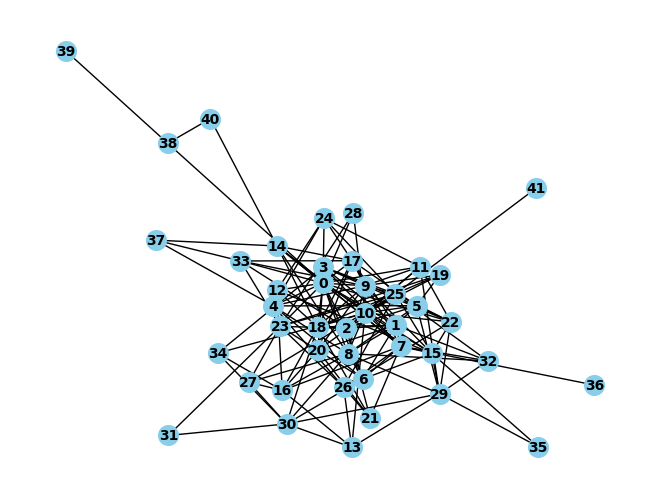

In [112]:
G_target = nx.from_numpy_array(output.squeeze().detach().numpy(), create_using=nx.Graph)
to_remove = []
for node in G_target.nodes():
    if G_target.degree(node) == 0:
        to_remove.append(node)
G_target.remove_nodes_from(to_remove)
nx.draw(G_target, with_labels=True, font_weight='bold', node_color='skyblue', node_size=200, font_size=10)

In [124]:
idx_shuffle_A

tensor([0])

In [ ]:
idx_shuffle_A = torch.randperm(n = input.A.shape[1])
shuffle_A = input.A[0][idx_shuffle_A, :]
shuffle_A

tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [120]:
input.A

tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [118]:
mae(input.A, shuffle_A)

np.float64(0.0)

In [121]:
(input.A == shuffle_A).all()

tensor(True)